In [1]:
import os
import io
import fnmatch
from json import load, dump

In [2]:
BASE_DIR = os.path.abspath(os.path.dirname(os.path.dirname('.')))
text_data_dir = os.path.join(BASE_DIR, 'data', 'solomon-100-original')
json_data_dir = os.path.join(BASE_DIR, 'data', 'solomon-100-json')

In [3]:
def calculate_distance(customer1, customer2):
    '''Calculate the Euclidean distance between two customers.
    In solomon instances, the travel time equals to the distances
    '''
    return ((customer1['coordinates']['x'] - customer2['coordinates']['x'])**2 + \
        (customer1['coordinates']['y'] - customer2['coordinates']['y'])**2)**0.5

def make_dirs_for_file(path):
    '''Attempt to create file directory.
    '''
    try:
        os.makedirs(os.path.dirname(path))
    except OSError:
        msg = "This directory does exist already."
        pass

## transfer the data into json format

In [28]:
for text_file in map(lambda text_filename: os.path.join(text_data_dir, text_filename), \
                     fnmatch.filter(os.listdir(text_data_dir), '*.txt')):
    json_data = {}
    with io.open(text_file, 'rt', encoding='utf-8', newline='') as file_object:
        for line_count, line in enumerate(file_object, start=1):
            if line_count in [2, 3, 4, 6, 7, 8, 9]: 
                pass
            elif line_count == 1:
                # <Instance name>
                json_data['instance_name'] = line.strip()
            elif line_count == 5:    
                # <Maximum vehicle number>, <Vehicle capacity>                
                values = line.strip().split()
                json_data['max_vehicle_number'] = int(values[0])
                json_data['vehicle_capacity'] = float(values[1])
            elif line_count == 10:
                # Custom number = 0, depot
                # <Custom number>, <X coordinate>, <Y coordinate>, 
                # ... <Demand>, <Ready time>, <Due date>, <Service time>
                values = line.strip().split()
                json_data['depot'] = {
                    'coordinates': {
                        'x': float(values[1]),
                        'y': float(values[2]),
                    },
                    'demand': float(values[3]),
                    'ready_time': float(values[4]),
                    'due_time': float(values[5]),
                    'service_time': float(values[6])
                }
            else:
                # <Custom number>, <X coordinate>, <Y coordinate>, 
                # ... <Demand>, <Ready time>, <Due date>, <Service time>
                values = line.strip().split()
                json_data[f'customer_{values[0]}'] = {
                    'coordinates': {
                        'x': float(values[1]),
                        'y': float(values[2]),
                    },
                    'demand': float(values[3]),
                    'ready_time': float(values[4]),
                    'due_time': float(values[5]),
                    'service_time': float(values[6])
                }            
    customers = ['depot'] + [f'customer_{x}' for x in range(1, 101)]
    json_data['distance_matrix'] = [[calculate_distance(json_data[customer1], \
            json_data[customer2]) for customer1 in customers] for customer2 in customers]    
    json_file_name = f"{json_data['instance_name']}.json"
    json_file = os.path.join(json_data_dir, json_file_name)
    print(f'Write to file: {json_file}')
    make_dirs_for_file(json_file)
    with io.open(json_file, 'wt', encoding='utf-8', newline='') as file_object:
        dump(json_data, file_object, sort_keys=True, indent=4, separators=(',', ': '))

Write to file: /data/home/exx866/VRPTW/data/solomon-100-json/RC201.json
Write to file: /data/home/exx866/VRPTW/data/solomon-100-json/RC204.json
Write to file: /data/home/exx866/VRPTW/data/solomon-100-json/RC206.json
Write to file: /data/home/exx866/VRPTW/data/solomon-100-json/C205.json
Write to file: /data/home/exx866/VRPTW/data/solomon-100-json/RC207.json
Write to file: /data/home/exx866/VRPTW/data/solomon-100-json/C106.json
Write to file: /data/home/exx866/VRPTW/data/solomon-100-json/R109.json
Write to file: /data/home/exx866/VRPTW/data/solomon-100-json/R204.json
Write to file: /data/home/exx866/VRPTW/data/solomon-100-json/C206.json
Write to file: /data/home/exx866/VRPTW/data/solomon-100-json/C107.json
Write to file: /data/home/exx866/VRPTW/data/solomon-100-json/R205.json
Write to file: /data/home/exx866/VRPTW/data/solomon-100-json/C101.json
Write to file: /data/home/exx866/VRPTW/data/solomon-100-json/RC105.json
Write to file: /data/home/exx866/VRPTW/data/solomon-100-json/RC106.json


## load json data

In [5]:
def guess_path_type(path):
    '''judge the path type
    '''
    if os.path.isfile(path):
        return 'File'
    if os.path.isdir(path):
        return 'Directory'
    if os.path.islink(path):
        return 'Symbolic Link'
    if os.path.ismount(path):
        return 'Mount Point'
    return 'Path'

def exist(path, overwrite=False, display_info=True):
    '''judge whether the file or path exist
    '''
    if os.path.exists(path):
        if overwrite:
            if display_info:
                print(f'{guess_path_type(path)}: {path} exists. Overwrite.')
            os.remove(path)
            return False
        if display_info:
            print(f'{guess_path_type(path)}: {path} exists.')
        return True
    if display_info:
        print(f'{guess_path_type(path)}: {path} does not exist.')
    return False


def load_instance(json_file):
    '''load python object from the file
    '''
    if exist(path=json_file, overwrite=False, display_info=True):
        with io.open(json_file, 'rt', encoding='utf-8', newline='') as file_object:
            return load(file_object)
    return None

In [6]:
instance_name = 'R101'
json_file = os.path.join(json_data_dir, f'{instance_name}.json')
instance = load_instance(json_file=json_file)
if instance is None:
    print('The instance is None')
    exit

File: /data/home/exx866/VRPTW/data/solomon-100-json/R101.json exists.


## plot the graph

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

In [7]:
# Read the instance and save the x, y coordinates in a dataframe object

# create a empty dataframe
df = pd.DataFrame(columns=['customer_no', 'x_pos', 'y_pos'], dtype=str)


for key in instance:
    if key.startswith("customer"):
        new_row = pd.DataFrame({'customer_no': [str(key)],
                                'x_pos': [instance[key]["coordinates"]["x"]],
                                'y_pos': [instance[key]["coordinates"]["y"]]
                               })
        df = pd.concat([df, new_row], ignore_index=True)
    elif key == "depot":
        new_row = pd.DataFrame({'customer_no': ["customer_0"],
                                'x_pos': [instance[key]["coordinates"]["x"]],
                                'y_pos': [instance[key]["coordinates"]["y"]]
                               })         
        df = pd.concat([df, new_row], ignore_index=True)
    else:
        next
df


,customer_no,x_pos,y_pos
0,customer_1,41.0,49.0
1,customer_10,30.0,60.0
2,customer_100,18.0,18.0
3,customer_11,20.0,65.0
4,customer_12,50.0,35.0
...,...,...,...
96,customer_96,22.0,27.0
97,customer_97,25.0,21.0
98,customer_98,19.0,21.0
99,customer_99,20.0,26.0


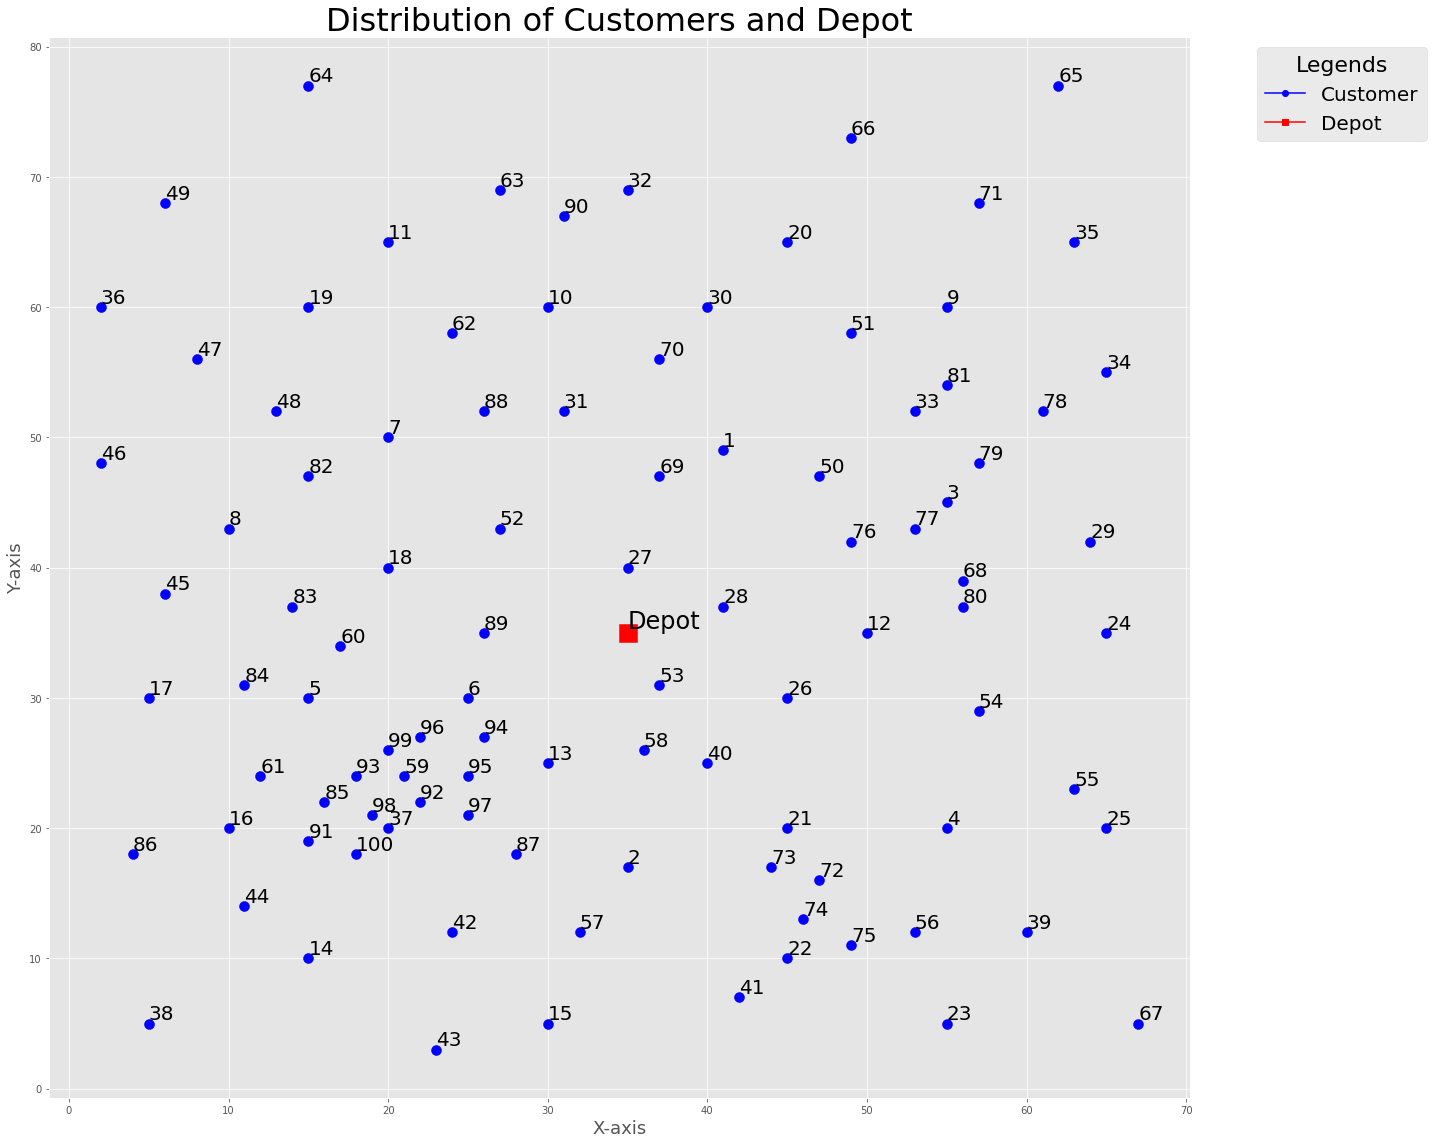

In [27]:
fig, ax = plt.subplots(figsize=(20, 16)) 


for i in range(len(df)):
    if df['customer_no'].loc[i] == 'customer_0':
        ax.scatter(df['x_pos'].loc[i], df['y_pos'].loc[i], color='red', marker='s', s=300)
        # Annotate the depot
        ax.text(df['x_pos'].loc[i], df['y_pos'].loc[i], "Depot", ha='left', va='bottom', fontsize=24)
    else:
        ax.scatter(df['x_pos'].loc[i], df['y_pos'].loc[i], color='blue', marker='o', s=100)
        # Annotate the customer
        ax.text(df['x_pos'].loc[i], df['y_pos'].loc[i], df['customer_no'].loc[i][9:], ha='left', va='bottom', fontsize=20)



# Set the plot title and axis labels
ax.set_title('Distribution of Customers and Depot', fontsize=32)
ax.set_xlabel('X-axis', fontsize=18)
ax.set_ylabel('Y-axis', fontsize=18)

# Create custom legend labels
custom_legend_labels = ['Customer', 'Depot']
custom_legend_markers = ['o', 's']
custom_legend_colors = ['blue', 'red']
legend_elements = [plt.Line2D([0], [0], marker=m, color=c, label=l) for m, c, l in zip(custom_legend_markers, custom_legend_colors, custom_legend_labels)]


# Add legend outside the plot
ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1), title="Legends", title_fontsize=22, fontsize=20)

# Adjust the layout to prevent overlapping text
plt.tight_layout()

# Show the plot
plt.show()
